## II Exploration vs. Exploitation

In reinforcement learning, particularly within the Multi-Armed Bandit (MAB) framework, the trade-off between exploration and exploitation is a fundamental dilemma. The agent must balance maximizing immediate rewards based on current knowledge with acquiring new information to make better decisions in the future.

### 1. Action-Value Estimation
To make informed decisions, the agent estimates the value (expected reward) of each action $a$, denoted as $Q_t(a)$, at time step $t$. This is typically calculated using the sample-average method. To compute this efficiently without storing all past rewards, we use the **incremental update rule**:

$$Q_{n+1} = Q_n + \frac{1}{n} (R_n - Q_n)$$

where $R_n$ is the $n$-th reward received for that action, and $n$ is the number of times the action has been selected. The term $(R_n - Q_n)$ acts as the temporal difference error.

### 2. Exploitation (Greedy Action)
* **Concept**: Selecting the action with the highest estimated value: $A_t = \arg\max_a Q_t(a)$.
* **Objective**: To maximize current short-term rewards.
* **Disadvantage**: Early estimates are highly prone to variance. Pure exploitation ($\epsilon = 0$) causes the algorithm to easily lock onto a "suboptimal action" that coincidentally yielded a high reward early on, leading to premature convergence and missing the true optimal action.

### 3. Exploration
* **Concept**: Forgoing the currently best-looking option to try random actions, regardless of their current value estimates.
* **Objective**: To gather more information, refine $Q$-value estimates, and discover truly high-reward actions in the long run.
* **Disadvantage**: Over-exploration (e.g., $\epsilon = 0.1$) means that even when the agent has confidently found the best action, it continues to waste 10% of its steps choosing blindly. This places an artificial ceiling on the maximum cumulative reward.

### 4. The Trade-off ($\epsilon$-greedy Strategy)
The $\epsilon$-greedy algorithm elegantly balances these two concepts. With probability $1 - \epsilon$, it exploits the best-known action; with probability $\epsilon$, it explores uniformly at random. 
In our experiments, $\epsilon = 0.01$ provides the optimal long-term balance. It spends 99% of its time greedily maximizing rewards and 1% of its time mitigating unknown risks. It resolves the premature convergence of pure greedy methods while avoiding the high regret penalty of over-exploration.

---
### Experimental Demonstration
The code below simulates a 10-Armed Testbed (averaging over 2000 independent runs for statistical significance) and compares three strategies. We track two critical metrics:
1. **Average Reward**: The magnitude of reward the agent receives over time.
2. **% Optimal Action**: The frequency with which the agent successfully identifies and selects the absolute best arm.

Simulating 2000 independent runs of 10-Armed Bandit...
Training agent with epsilon = 0.0...
Training agent with epsilon = 0.01...
Training agent with epsilon = 0.1...
The Picture successfully saved!


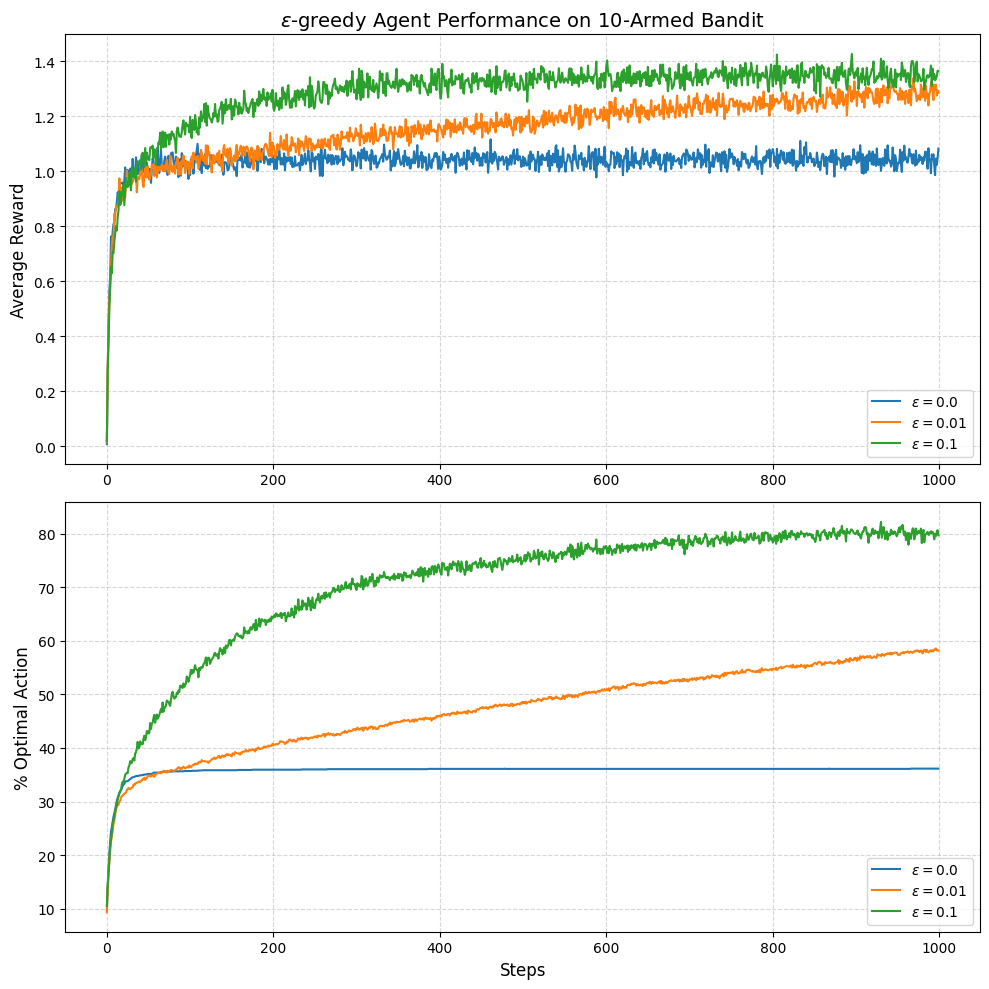

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Define the Multi-Armed Bandit Environment
class BanditEnvironment:
    def __init__(self, k=10):
        self.k = k
        # The true action values are selected from a standard normal distribution
        self.q_true = np.random.randn(k)
        # Identify the true best action for tracking performance
        self.best_action = np.argmax(self.q_true)

    def step(self, action):
        # Reward is drawn from a normal distribution with mean q_true[action] and variance 1
        return np.random.randn() + self.q_true[action]

# 2. Define the epsilon-greedy training loop
def run_epsilon_greedy(epsilon, k=10, steps=1000, runs=2000):
    """
    Runs the epsilon-greedy algorithm and averages metrics over multiple independent runs.
    """
    avg_rewards = np.zeros(steps)
    optimal_action_pct = np.zeros(steps)
    
    for run in range(runs):
        env = BanditEnvironment(k)
        q_estimates = np.zeros(k)   # Q_1(a) = 0
        action_counts = np.zeros(k) # N(a) = 0
        
        for step in range(steps):
            # Action Selection: Epsilon-greedy
            if np.random.rand() < epsilon:
                action = np.random.choice(k) # Explore randomly
            else:
                # Exploit: robust argmax that randomly breaks ties
                best_val = np.max(q_estimates)
                best_actions = np.where(q_estimates == best_val)[0]
                action = np.random.choice(best_actions)
            
            # Execute action
            reward = env.step(action)
            
            # Incremental update rule: Q_{n+1} = Q_n + 1/n * (R_n - Q_n)
            action_counts[action] += 1
            q_estimates[action] += (1.0 / action_counts[action]) * (reward - q_estimates[action])
            
            # Record metrics
            avg_rewards[step] += reward
            if action == env.best_action:
                optimal_action_pct[step] += 1
                
    # Average the results across all runs
    avg_rewards /= runs
    optimal_action_pct = (optimal_action_pct / runs) * 100 # Convert to percentage
    
    return avg_rewards, optimal_action_pct

# 3. Execute Experiments
k_arms = 10
steps = 1000
runs = 2000  # 2000 runs ensures smooth, statistically significant curves
epsilons = [0.0, 0.01, 0.1]

results_rewards = {}
results_optimal = {}

print(f"Simulating {runs} independent runs of {k_arms}-Armed Bandit...")
for eps in epsilons:
    print(f"Training agent with epsilon = {eps}...")
    rew, opt = run_epsilon_greedy(eps, k=k_arms, steps=steps, runs=runs)
    results_rewards[eps] = rew
    results_optimal[eps] = opt

# 4. Plotting the Dual Metrics
plt.figure(figsize=(10, 10))

# Top Plot: Average Reward 
plt.subplot(2, 1, 1)
for eps in epsilons:
    plt.plot(results_rewards[eps], label=f'$\epsilon={eps}$')
plt.ylabel('Average Reward', fontsize=12)
plt.title('$\epsilon$-greedy Agent Performance on 10-Armed Bandit', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

# Bottom Plot: % Optimal Action
plt.subplot(2, 1, 2)
for eps in epsilons:
    plt.plot(results_optimal[eps], label=f'$\epsilon={eps}$')
plt.xlabel('Steps', fontsize=12)
plt.ylabel('% Optimal Action', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

folder_name = '.'
plt.tight_layout()
save_path = os.path.join(folder_name, 'figure_problem2.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"The Picture successfully saved!")
plt.show()

## Conclusion: Analyzing the $\epsilon$-greedy Performance


Based on the theoretical framework and the empirical results generated by our simulation, we can draw the following key conclusions regarding the Exploration-Exploitation dilemma:

1. **The Trap of Pure Exploitation ($\epsilon = 0.0$)**:
   The curve representing the pure greedy strategy plateaus very early. As seen in the "% Optimal Action" plot, without exploration, the agent frequently locks onto a suboptimal arm that merely happened to yield a high initial reward. It demonstrates the lowest long-term performance, proving that solely relying on uncertain early estimates is an ineffective strategy.

2. **The Ceiling of Over-Exploration ($\epsilon = 0.1$)**:
   A higher exploration rate allows the agent to discover the optimal action much faster in the early stages (as shown by its steep initial climb). However, its long-term performance is strictly capped. Because it is forced to select a completely random action 10% of the time, its "% Optimal Action" curve hits a hard ceiling. It sacrifices too much short-term reward for unnecessary information gathering later on.

3. **The Optimal Trade-off ($\epsilon = 0.01$)**:
   This strategy perfectly illustrates the power of balanced exploration. While it learns slower than $\epsilon=0.1$ in the first few hundred steps, it eventually surpasses it. By exploring just 1% of the time, it steadily uncovers the true optimal action without paying a heavy "exploration tax," ultimately achieving the highest average reward and optimal action percentage by the end of the simulation.

**Final Verdict**: 
The empirical results beautifully validate the theoretical dilemma. In a stationary Multi-Armed Bandit environment, a small, persistent exploration rate ($\epsilon = 0.01$) provides the optimal balance, preventing premature convergence while maximizing long-term cumulative rewards.